# Setup

In [1]:
# !pip install transformers accelerate opencv-python torchlibrosa pydub ffmpeg-python vit-pytorch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import glob
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
import multiprocessing as mp
import cv2
from scipy.signal import resample
import wave
from sklearn.model_selection import train_test_split
import ffmpeg
# import librosa
from pydub import AudioSegment
import io

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

import variables as var

In [4]:
# var.TO_PATH = "/content/drive/MyDrive/Thesis/PREP/sub_data"

In [5]:
# prep_df = pd.read_csv("/content/drive/MyDrive/Thesis/PREP/prepped_df.csv")
prep_df = pd.read_csv("data/SnapUGC/prepped_df.csv")

# remove unused columns
prep_df.drop(columns=["Title", "Description"], inplace=True)

prep_df

prep_df

,Id,Video_len,order of ECR,order of NAWP,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,train,0.000000,0.000000
...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,test,0.012459,0.999924


In [6]:
downloaded_videos = os.listdir(var.DOWNLOAD_PATH + "/train")
downloaded_videos += os.listdir(var.DOWNLOAD_PATH + "/test")
downloaded_videos = [s.removesuffix(".mp4") for s in downloaded_videos]

prep_df = prep_df[prep_df["Id"].isin(downloaded_videos)]
prep_df

,Id,Video_len,order of ECR,order of NAWP,Set,ECR,NAWP
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,train,0.000000,0.000000
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,train,0.000000,0.000000
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,train,0.000000,0.000000
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,train,0.000000,0.000000
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,train,0.000000,0.000000
...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,test,0.269961,0.999466
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,test,0.371187,0.999596
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,test,0.275392,0.999893
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,test,0.012459,0.999924


In [7]:
# def find_matching_ids(directory):
#     npz_ids = set()
#     wav_ids = set()

#     for file in os.listdir(directory):
#         if file.endswith(".npz"):
#             npz_ids.add(file[:-4])  # Remove .npz
#         elif file.endswith(".wav"):
#             wav_ids.add(file[:-4])  # Remove .wav

#     common_ids = npz_ids & wav_ids  # Find IDs present in both sets
#     return sorted(common_ids)

# existed_ids_train = find_matching_ids(var.TO_PATH + "/train")
# existed_ids_test = find_matching_ids(var.TO_PATH + "/test")

# prep_df = prep_df[prep_df["Id"].isin(existed_ids_train) | prep_df["Id"].isin(existed_ids_test)]
# prep_df.reset_index(drop=True, inplace=True)
# len(prep_df)

In [8]:
prep_df.sample(10)

,Id,Video_len,order of ECR,order of NAWP,Set,ECR,NAWP
28905,2240e639b470d5902b694883fe19a80f,10.733333,81814,81879,train,0.640302,0.624554
29271,409291947269514e8de8d5ff700b5bec,11.866667,78550,83310,train,0.614757,0.635469
6769,1307bf5abb7824e9c1eec634efc2b07a,18.066667,15498,11253,train,0.121292,0.085835
946,e737073ee72d432e4d4466d24b7c28e2,12.500000,2600,1457,train,0.020348,0.011114
40169,084ca936b240d36f8f1a350235b09c83,59.766667,123954,114944,train,0.970103,0.876766
50654,380dfc49e00f1b74ea853d5795960e18,36.900000,125677,130438,train,0.983588,0.994950
15112,142263eba20acd05f8c11d062958c69e,13.100000,31744,30417,train,0.248439,0.232014
23554,e4797305ef8ceaa88361b5ca035fcb24,17.466667,54204,59129,train,0.424218,0.451022
55921,2197b4f66d1b2ce5a2c3b979a83689f1,15.710306,105290,108155,test,0.824033,0.824981
16309,908e723875324f10324faad5598f7ce7,11.700000,38153,33695,train,0.298598,0.257018


# Check distribution

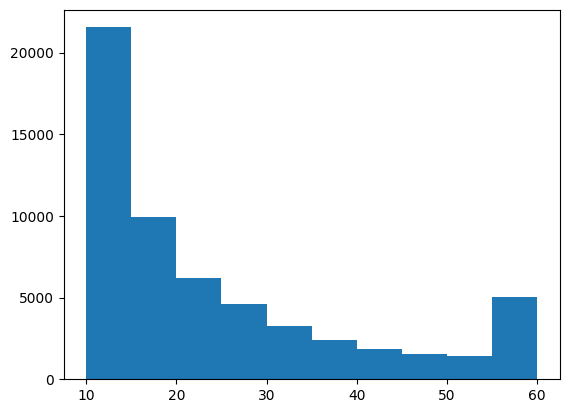

In [9]:
plt.hist(prep_df['Video_len'])
plt.show()

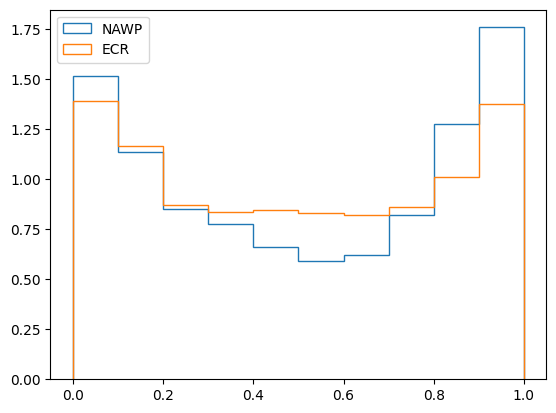

In [10]:
plt.hist(prep_df['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

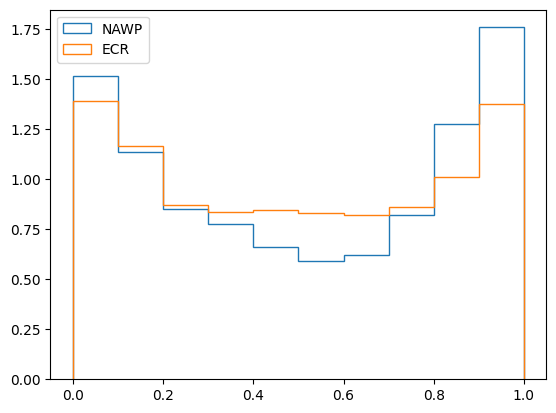

In [11]:
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['NAWP'], density=True, histtype='step', label='NAWP')
plt.hist(prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]['ECR'], density=True, histtype='step', label='ECR')
plt.legend()
plt.show()

In [12]:
prep_df = prep_df[prep_df['Video_len'] <= var.MAX_SECONDS]

In [13]:
prep_df['NAWP'].min(), prep_df['NAWP'].max(), prep_df['ECR'].min(), prep_df['ECR'].max()

(np.float64(0.0),
 np.float64(0.9999771167048056),
 np.float64(0.0),
 np.float64(1.0))

# Load data

In [14]:
sample_video = prep_df.sample(1).iloc[0]
sample_video

Id               0d9db108f47db8b902db8d264bd391ab
Video_len                               16.266667
order of ECR                                58357
order of NAWP                               55425
Set                                         train
ECR                                       0.45672
NAWP                                     0.422769
Name: 22604, dtype: object

Sample ID: 0d9db108f47db8b902db8d264bd391ab
Loaded Video Shape: (81, 224, 128, 3)
Loaded Audio Shape: (259692,)


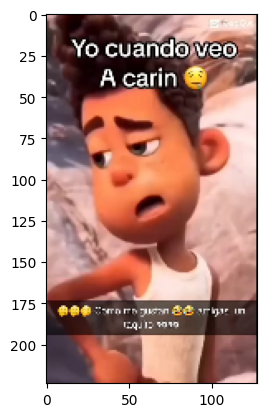

In [15]:
def load_video_audio(video_path, 
                    target_height=var.TARGET_FRAME_SIZE[0], target_width=var.TARGET_FRAME_SIZE[1], target_fps=var.VIDEO_FPS, 
                    target_sample_rate=var.AUDIO_FPS,
                    start=0, end=None):
    """
    Extracts video frames and audio from a video file between start and end seconds, with resizing and downsampling.
    """
    # ---- Extract Video Frames with Fixed FPS ----
    cap = cv2.VideoCapture(video_path)
    original_fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    duration = total_frames / original_fps

    if end is None or end > duration:
        end = duration

    start_frame = int(start * original_fps)
    end_frame = int(end * original_fps)
    frame_interval = original_fps / target_fps if target_fps is not None else 1

    frames = []
    frame_idx = 0

    cap.set(cv2.CAP_PROP_POS_FRAMES, start_frame)

    while cap.isOpened():
        current_pos = cap.get(cv2.CAP_PROP_POS_FRAMES)
        if current_pos >= end_frame:
            break

        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % round(frame_interval) == 0:
            h, w, _ = frame.shape

            # Resize with padding
            scale = min(target_width / w, target_height / h)
            new_w, new_h = int(w * scale), int(h * scale)
            resized_frame = cv2.resize(frame, (new_w, new_h))
            resized_frame = cv2.cvtColor(resized_frame, cv2.COLOR_BGR2RGB)

            padded_frame = np.zeros((target_height, target_width, 3), dtype=np.uint8)
            pad_top = (target_height - new_h) // 2
            pad_left = (target_width - new_w) // 2
            padded_frame[pad_top:pad_top+new_h, pad_left:pad_left+new_w] = resized_frame

            frames.append(padded_frame)

        frame_idx += 1

    cap.release()
    video_array = np.array(frames, dtype=np.uint8)

    # ---- Extract and Downsample Audio (Trimmed) ----
    ffmpeg_args = {
        'format': 'wav',
        'ar': target_sample_rate,
        'ac': 1
    }

    input_args = {}
    if start != 0 and end is not None:
        input_args['ss'] = start
        input_args['to'] = end

    out, _ = (
        ffmpeg
        .input(video_path, **input_args)
        .output("pipe:", **ffmpeg_args)
        .run(capture_stdout=True, capture_stderr=True)
    )

    audio = AudioSegment.from_file(io.BytesIO(out), format="wav")
    samples = np.array(audio.get_array_of_samples(), dtype=np.int16)

    return video_array, samples



print(f"Sample ID: {sample_video['Id']}")

video_loaded, audio_loaded = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample_video['Set'], sample_video['Id'] + ".mp4"),
                                              start=0, end=None)
print(f"Loaded Video Shape: {video_loaded.shape}")  # (num_frames, height, width, 3)
print(f"Loaded Audio Shape: {audio_loaded.shape}")

plt.imshow(video_loaded[0])
plt.show()

# Create dataset

Numeric to label

In [16]:
THRESHOLD = 0.5 # [0.3, 0.7]

def get_label(x):
    if type(THRESHOLD) == list:
        if x < THRESHOLD[0]:
            return 0
        elif x > THRESHOLD[1]:
            return 2
        else:
            return 1
    else:
        if x < THRESHOLD:
            return 0
        else:
            return 1

prep_df['Target'] = prep_df['NAWP'].apply(get_label) # small ECR is positive
prep_df

,Id,Video_len,order of ECR,order of NAWP,Set,ECR,NAWP,Target
0,5902367b4d7d4c38fe4638593ddea7ee,42.400000,0,0,train,0.000000,0.000000,0
1,9be2d4d5e8d4bfd1f5ce59f51d7d96dd,15.582233,0,0,train,0.000000,0.000000,0
2,1d5a6586d42b5b0d69f48a7ba87fccfe,18.300000,0,0,train,0.000000,0.000000,0
3,1e9b26ba367a8ed559916599294bbfc1,45.866667,0,0,train,0.000000,0.000000,0
4,e86dbca9869239fcf2d04373f9efd38e,29.880000,0,0,train,0.000000,0.000000,0
...,...,...,...,...,...,...,...,...
57833,58ec27987a35909f4006f136118c6940,21.033333,34494,131030,test,0.269961,0.999466,1
57834,26e446b86f92faa89d88a58d03ea24bb,10.700000,47428,131047,test,0.371187,0.999596,1
57835,72ae9bac4dd52c9e6befc90d9bae710c,12.900000,35188,131086,test,0.275392,0.999893,1
57836,f548dd1f4b64e5ca3f2c7780871a08c5,10.000000,1592,131090,test,0.012459,0.999924,1


In [17]:
def to_num_frames(video_array, target_frame):
    num_frames = video_array.shape[0]

    if num_frames == target_frame:
        return video_array
    elif num_frames < target_frame:
        # Pad with zeros if fewer frames than target
        padding = np.zeros((target_frame - num_frames, video_array.shape[1], video_array.shape[2], video_array.shape[3]), dtype=np.uint8)
        return np.concatenate((video_array, padding), axis=0)

    indices = np.linspace(0, num_frames - 1, target_frame).astype(int)
    return video_array[indices]

In [18]:
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import wave
import os

config = {
    'frame_size': 224,
    'video_fps': None,
    'num_frames': 32,
    'audio_hz': 16000,
    'max_seconds': 60
}

class VideoAudioDataset(Dataset):
    def __init__(self, df):
        self.df = df

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sample = self.df.iloc[idx]
        sample_id = sample["Id"]

        video_array, audio_array = load_video_audio(os.path.join(var.DOWNLOAD_PATH, sample["Set"], sample_id + ".mp4"),
                                                    target_height=config['frame_size'],
                                                    target_width=config['frame_size'],
                                                    target_fps=config['video_fps'],
                                                    target_sample_rate=config['audio_hz'],
                                                    start=0, end=config['max_seconds'])

        video_array = to_num_frames(video_array, target_frame=config['num_frames'])

        # plt.imshow(video_array[0])
        # plt.show()
        # input()

        # Normalize video frames
        # video_array = video_array.astype(np.float32) / 255.0
        
        # # Normalize audio samples to [-1, 1]
        # audio_array = audio_array.astype(np.float32) / 32768.0
        # audio_array = audio_array - np.mean(audio_array)
        # audio_array = audio_array / np.max(np.abs(audio_array))

        # Convert to tensors
        video_tensor = torch.tensor(video_array, dtype=torch.float32)
        audio_tensor = torch.tensor(audio_array, dtype=torch.float32)
        
        
        label =  sample['Target'] #  # [sample['ECR'], sample['NAWP']]
        label_tensor = torch.tensor(label,  dtype=torch.long) # dtype=torch.long)

        return {
            "id": sample_id,
            "video": video_tensor,
            "audio": audio_tensor,
            "label": label_tensor
        }

def collate_fn(batch, max_frames, max_audio_samples):
    """Custom collate function to pad frames and audio."""

    video_tensors = []
    audio_tensors = []
    labels = []
    ids = []
    sample_rates = []

    for sample in batch:
        video = sample["video"]
        audio = sample["audio"]
        num_frames = video.shape[0]
        num_audio_samples = audio.shape[0]

        # # To fix num video frames
        padded_video = video # to_num_frames(video)

        # Pad audio samples
        if num_audio_samples < max_audio_samples:
            pad_audio = max_audio_samples - num_audio_samples
            padded_audio = torch.cat([audio, torch.zeros(pad_audio)], dim=0)
        else:
            padded_audio = audio[:max_audio_samples]

        video_tensors.append(padded_video)
        audio_tensors.append(padded_audio)
        labels.append(sample["label"])
        ids.append(sample["id"])

    return {
        "id": ids,
        "video": torch.stack(video_tensors),  # (batch_size, num_frames, C, H, W)
        "audio": torch.stack(audio_tensors),  # (batch_size, audio_length)
        "label": torch.stack(labels)  # (batch_size,)
    }

# Split data

In [19]:
# test with small subset
prep_df = prep_df.sample(frac=0.1, random_state=42).reset_index(drop=True)

In [20]:
train_df = prep_df[prep_df["Set"] == "train"]

train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=42)

test_df = prep_df[prep_df["Set"] == "test"]

len(train_df), len(val_df), len(test_df)

(4065, 1017, 702)

In [21]:
BATCH_SIZE = 2

In [22]:
trainset = VideoAudioDataset(train_df)
valset = VideoAudioDataset(val_df)
testset = VideoAudioDataset(test_df)

train_loader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True,  num_workers=4,
                          collate_fn=lambda x: collate_fn(x, max_frames=config['num_frames'], max_audio_samples=config['audio_hz'] * config['max_seconds']))

val_loader = DataLoader(valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                          collate_fn=lambda x: collate_fn(x, max_frames=config['num_frames'], max_audio_samples=config['audio_hz'] * config['max_seconds']))

test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4,
                          collate_fn=lambda x: collate_fn(x, max_frames=config['num_frames'], max_audio_samples=config['audio_hz'] * config['max_seconds']))


In [23]:
# sample_batch = next(iter(train_loader))

# sample_batch['id'], sample_batch['video'].shape, sample_batch['audio'].shape, sample_batch['label'].shape

# Define model

## Video encoder

In [24]:
import torch
import torch.nn as nn
from vit_pytorch.vivit import ViT

class VideoEncoder3DViT(nn.Module):
    def __init__(self, out_dim=512, dropout=0.3):
        super().__init__()
        self.vivit = ViT(
            image_size = 224,          # image size
            frames = config['num_frames'],               # number of frames
            image_patch_size = 16,     # image patch size
            frame_patch_size = 2,      # frame patch size
            num_classes = out_dim,
            dim = 1024,
            spatial_depth = 6,         # depth of the spatial transformer
            temporal_depth = 6,        # depth of the temporal transformer
            heads = 8,
            mlp_dim = 2048,
            dropout = dropout,
            variant = 'factorized_encoder', # or 'factorized_self_attention'
        )
        
        self.lnorm = nn.LayerNorm(out_dim)

    def forward(self, x):  # (B, T, H, W, 3)
        x = x / 255.0  # Normalize to [0, 1]
        x = x.permute(0, 4, 1, 2, 3)  # (B, C, T, H, W)
        x = self.vivit(x)  # (B, dim)
        x = self.lnorm(x)  # (B, dim)
        return x

class AudioEncoder(nn.Module):
    def __init__(self, out_dim=512):
        super(AudioEncoder, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Conv1d(32, 64, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.fc = nn.Linear(256, out_dim)
        self.lnorm = nn.LayerNorm(out_dim)


    def forward(self, x):  # x: (B, N)
        x = torch.clamp(x / 32768.0, -1.0, 1.0)  # Normalize to [-1, 1] with clamping
        x = x.unsqueeze(1)  # (B, 1, N)
        x = self.cnn(x)  # (B, 128, 1)
        x = x.view(x.size(0), -1)  # (B, 128)
        x = self.fc(x)  # (B, out_dim)
        x = self.lnorm(x)
        return x

class AudioVisualModel(nn.Module):
    def __init__(self, fusion_dim=1024):
        super(AudioVisualModel, self).__init__()
        self.video_encoder = VideoEncoder3DViT(out_dim=512)
        self.audio_encoder = AudioEncoder(out_dim=512)
        self.fusion = nn.Sequential(
            nn.Linear(1024, fusion_dim),
            nn.ReLU(),
            nn.LayerNorm(fusion_dim)
        )

    def forward(self, video_frames, audio_waveform):
        # video_frames: (B, T, H, W, 3)
        # audio_waveform: (B, N)
        video_feat = self.video_encoder(video_frames)  # (B, 512)
        audio_feat = self.audio_encoder(audio_waveform)  # (B, 512)
        fused = torch.cat([video_feat, audio_feat], dim=-1)  # (B, 1024)
        return self.fusion(fused)  # (B, 1024)

In [25]:
# sample_batch = next(iter(train_loader))


# device = 'cpu'
# model = AudioVisualModel(fusion_dim=768).to(device)
# model(sample_batch["video"].to(device), sample_batch["audio"].to(device)).shape

## Text encoder

In [26]:
import json

json_path = 'data/SnapUGC/sample_concepts.json'

# === Load Concepts ===
with open(json_path, 'r') as f:
    concept_dict = json.load(f)

concepts = []
concept2cls = []
classnames = list(concept_dict.keys())
for cls_idx, cls_name in enumerate(classnames):
    for concept in concept_dict[cls_name]:
        concepts.append(concept)
        concept2cls.append(cls_idx)

concept2cls = torch.tensor(concept2cls, dtype=torch.long)
select_idx = torch.arange(len(concepts))


print(f"Loaded {len(concepts)} total concepts.")

Loaded 130 total concepts.


In [27]:
import torch
from tqdm import tqdm
from transformers import CLIPTokenizer, CLIPTextModel

# === Config ===
output_path = 'prepare'
model_name = 'openai/clip-vit-large-patch14'
device = 'cpu'

os.makedirs(output_path, exist_ok=True)

try:
    concept_features = torch.tensor(np.load(f'{output_path}/concepts_feat.npy'))
    
except Exception as e:
    print(f"Error: {e}\nRecreate concept features.")

    # === Load tokenizer and model ===
    tokenizer = CLIPTokenizer.from_pretrained(model_name)
    text_encoder = CLIPTextModel.from_pretrained(model_name).to(device)
    text_encoder.eval()

    # === Tokenize and Encode ===
    batch_size = 32
    concept_features = []

    with torch.no_grad():
        for i in tqdm(range(0, len(concepts), batch_size)):
            batch = concepts[i:i+batch_size]
            tokens = tokenizer(batch, return_tensors='pt', padding=True, truncation=True).to(device)
            outputs = text_encoder(**tokens)
            last_hidden_state = outputs.last_hidden_state  # shape: (B, 77, D)
            text_embeds = last_hidden_state[:, 0, :]  # take CLS token (like CLIP does)
            text_embeds = text_embeds / text_embeds.norm(dim=-1, keepdim=True)  # normalize
            concept_features.append(text_embeds.cpu())

    concept_features = torch.cat(concept_features, dim=0).clone().detach()

    # === Save ===
    np.save(f'{output_path}/concepts_feat.npy', concept_features)


print(f"Concepts shape: {concept_features.shape}")
print(f"Concept2cls shape: {concept2cls.shape}")
print(f"Select_idx shape: {select_idx.shape}")

Concepts shape: torch.Size([130, 768])
Concept2cls shape: torch.Size([130])
Select_idx shape: torch.Size([130])


In [28]:
# import torch
# import numpy as np
# from sklearn.manifold import TSNE
# import plotly.express as px

# # === Load embeddings and labels ===
# concept_feats = concept_features
# concept_raw = concepts


# features_np = concept_feats.numpy()
# labels_np = concept2cls.numpy()
# concept_texts = np.array(concept_raw)

# # === Run t-SNE ===
# tsne = TSNE(n_components=2, random_state=42, perplexity=5)
# reduced_feats = tsne.fit_transform(features_np)

# # === Build dataframe for Plotly ===
# import pandas as pd

# df = pd.DataFrame({
#     "id": select_idx,
#     "x": reduced_feats[:, 0],
#     "y": reduced_feats[:, 1],
#     "class": ["engaged" if l == 0 else "not_engaged" for l in labels_np],
#     "concept": concept_texts
# })

# # === Plot ===
# fig = px.scatter(
#     df, x="x", y="y", color="class",
#     title="t-SNE of CLIP Text Embeddings (Concepts)",
#     hover_data=["concept", "id"],
#     template="plotly_white",
# )

# fig.update_traces(marker=dict(size=12, line=dict(width=1, color='DarkSlateGrey')))
# fig.update_layout(title_font_size=20, legend_title_text='Class')
# fig.show()


## Asso opt model

In [29]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class ClassificationHead(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.classifier = nn.Linear(input_dim, num_classes)
        
    def forward(self, x):
        return self.classifier(x)

class AssoOptModel(nn.Module):
    def __init__(self, av_model, text_features, num_classes, num_concepts):
        super().__init__()
        self.av_model = av_model
        self.text_features = text_features  # (num_concepts, D)
        self.asso_mat = nn.Parameter(torch.zeros((num_classes, num_concepts), device=device), requires_grad=True)
        
        self.linear_head = ClassificationHead(input_dim=text_features.shape[1], num_classes=num_classes)

    def forward(self, video, audio, cfg):
        if cfg['stage'] == 1:
            feat = self.av_model(video, audio)  # (B, D)
            return self.linear_head(feat)
        else:
            if cfg['tune_vid']:
                feat = self.av_model(video, audio)
            else:
                with torch.no_grad():
                    feat = self.av_model(video, audio)  # (B, D)
            
            # Compute class features from concept association
            weight_mat = self.get_weight_mat(cfg) 
            
            class_feat = weight_mat @ self.text_features  # (num_classes, D)
            # class_feat = class_feat / class_feat.norm(dim=-1, keepdim=True)  # normalize class features

            sim = feat @ class_feat.T  
            pred = 100 * sim
            return pred


    def get_weight_mat(self, cfg):
        if cfg["asso_act"] == "relu":
            return F.relu(self.asso_mat)
        elif cfg["asso_act"] == "tanh":
            return torch.tanh(self.asso_mat)
        elif cfg["asso_act"] == "softmax":
            return F.softmax(self.asso_mat, dim=-1)
        return self.asso_mat


In [44]:
class NormalCBM(nn.Module):
    def __init__(self, av_model, text_features, num_classes, num_concepts):
        super().__init__()
        self.av_model = av_model
        self.text_features = text_features  # (num_concepts, D)
        self.concepts_head = ClassificationHead(input_dim=768, num_classes=num_concepts)
        self.class_head = ClassificationHead(input_dim=text_features.shape[1], num_classes=num_classes)

    def forward(self, video, audio, cfg):
        x = self.av_model(video, audio)  # (B, D)
        x = self.concepts_head(x)  # (B, num_concepts)
        x = torch.softmax(x, dim=-1)
        # print(x.shape)
        
        x = x @ self.text_features
        # print(x.shape)
        x = self.class_head(x)
        return x

# Train step

In [45]:
def training_step(batch, model, optimizer, cfg):
    model.train()
    video = batch["video"].cuda()       # (B, T, H, W, 3)
    audio = batch["audio"].cuda()       # (B, N)
    label = batch["label"].cuda()       # (B, 2)

    # Forward pass
    pred = model(video, audio, cfg)
    # Classification loss
    # pred = torch.sigmoid(pred)
    # cls_loss = F.mse_loss(pred, label)
        
    cls_loss = F.cross_entropy(pred, label)

    # Regularization
    final_loss = cls_loss

    if cfg['stage'] == 2:
        if cfg["use_l1_loss"]:
            l1_reg = torch.linalg.vector_norm(model.asso_mat, ord=1, dim=-1).max()
            final_loss += cfg["lambda_l1"] * l1_reg

        if cfg["use_div_loss"]:
            div = -torch.var(pred / 100, dim=0).mean() # pred / 100 = sim
            final_loss += cfg["lambda_div"] * div

    # Backpropagation
    optimizer.zero_grad()
    final_loss.backward()
    # print(f"Gradient norm: {torch.norm(model.asso_mat.grad).item()}")

    optimizer.step()

    return {
        "loss": final_loss.item(),
        "pred": pred.detach(),
        "label": label.detach()
    }

@torch.no_grad()
def validation_step(batch, model, cfg):
    model.eval()
    video = batch["video"].cuda()       # (B, T, C, H, W)
    audio = batch["audio"].cuda()       # (B, N)
    label = batch["label"].cuda()       # (B, 2)

    # Forward pass
    pred = model(video, audio, cfg)
        
    # Classification loss (same as training)
    cls_loss = F.cross_entropy(pred, label)

    # Convert logits to probabilities and binary predictions (optional)
    prob = torch.sigmoid(pred)

    return {
        "loss": cls_loss.item(),
        "pred": pred.detach().cpu(),
        "prob": prob.detach().cpu(),
        "label": label.detach().cpu()
    }

# Training

In [46]:
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.optim as optim

# === Config ===
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# === Setup model ===
text_features = concept_features.clone().detach().to(device)  # (num_concepts, D) from frozen CLIP text encoder
num_classes = 2
num_concepts = text_features.shape[0]

In [47]:
av_model = AudioVisualModel(fusion_dim=text_features.shape[1]).to(device)

model = NormalCBM(av_model, text_features, num_classes, num_concepts).to(device)

# Normalize text features
# text_features /= text_features.norm(dim=-1, keepdim=True)  # (num_concepts, D)

# model = AssoOptModel(av_model, text_features, num_classes, num_concepts).to(device)


In [48]:
checkpoints_path = "cbm_checkpoints"
os.makedirs(checkpoints_path, exist_ok=True)
# model.load_state_dict(torch.load(f"small_checkpoints/snap_stage_1_best.pth"))

## Stage 1

In [49]:
cfg = {
    'stage': 1,
    'num_epochs': 5,
}

In [50]:
# === Training Loop ===
start_from_epoch = 0

optimizer = optim.Adam(model.parameters(), lr=0.0001)

# First train only the AV model
cfg['stage'] = 1

best_val_acc = 0.0  # Track best validation accuracy

for epoch in range(cfg['num_epochs']):
    if epoch < start_from_epoch:    
        continue
    
    # TRAINING
    model.train()
    total_loss = 0
    cc = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in pbar:
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        metrics = training_step(batch, model, optimizer, cfg)
        
        # Accumulate loss
        total_loss += metrics["loss"]
        
        # Calculate accuracy
        pred_classes = torch.argmax(metrics["pred"], dim=1)
        correct += (pred_classes == metrics["label"]).sum().item()
        total += metrics["label"].size(0)
        train_acc = 100 * correct / total if total > 0 else 0
        
        # Logging
        if cc % 100 == 0:
            normalized_pred = torch.softmax(metrics["pred"], dim=-1)
            pbar.write(f"\tProb: {normalized_pred}")
            pbar.write(f"\tPred: {pred_classes}, Label: {metrics['label']}")
            pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
            # pbar.write(f"\tPred: {metrics["pred"]}, Label: {metrics['label']}")
            # pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
        cc += 1
        
        # Update progress bar
        pbar.set_postfix({
            "Avg Loss": f"{total_loss / cc:.4f}",
            "Acc": f"{train_acc:.2f}%"
        })
    
    # Final training metrics for this epoch
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total if total > 0 else 0
    
    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_pbar = tqdm(val_loader, desc=f"Validation")
    
    with torch.no_grad():
        for batch in val_pbar:
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            metrics = validation_step(batch, model, cfg)
            
            # Accumulate loss
            val_loss += metrics["loss"]
            
            # Calculate accuracy
            val_pred_classes = torch.argmax(metrics["pred"], dim=1)
            val_correct += (val_pred_classes == metrics["label"]).sum().item()
            val_total += metrics["label"].size(0)
            val_acc = 100 * val_correct / val_total if val_total > 0 else 0
            
            # Update progress bar
            val_pbar.set_postfix({
                "Avg Loss": f"{val_loss / (val_pbar.n + 1):.4f}",
                "Acc": f"{val_acc:.2f}%"
            })
    
    # Final validation metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total if val_total > 0 else 0
    
    # Save model if it's the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_1_best.pth")
        print(f"New best model saved with accuracy: {val_acc:.2f}%")
        
    # Always save epoch checkpoint
    torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_1_epoch_{epoch + 1}.pth")

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

Epoch 1:   0%|          | 1/2033 [00:08<4:47:45,  8.50s/it, Avg Loss=0.6932, Acc=50.00%]

	Prob: tensor([[0.4982, 0.5018],
        [0.4982, 0.5018]], device='cuda:0')
	Pred: tensor([1, 1], device='cuda:0'), Label: tensor([0, 1], device='cuda:0')
	Loss: 0.6932


Epoch 1:   5%|▍         | 101/2033 [15:11<4:54:17,  9.14s/it, Avg Loss=0.6934, Acc=50.50%]

	Prob: tensor([[0.4996, 0.5004],
        [0.4996, 0.5004]], device='cuda:0')
	Pred: tensor([1, 1], device='cuda:0'), Label: tensor([1, 1], device='cuda:0')
	Loss: 0.6923


Epoch 1:   6%|▌         | 116/2033 [17:38<4:51:31,  9.12s/it, Avg Loss=0.6934, Acc=48.71%]


KeyboardInterrupt: 

In [ ]:
asdf

## Stage 2

In [ ]:
cfg = {
    'stage': 2,
    'tune_vid': True,
    'learning_rate': 0.0001,
    'num_epochs': 5,
    
    "asso_act": "relu",       # "relu", "tanh", "softmax", or None
    "use_l1_loss": False,
    "lambda_l1": 0.01,
    "use_div_loss": False,
    "lambda_div": 0.005,
}


In [ ]:
# === Training Loop ===

model.asso_mat = nn.Parameter(torch.randn((num_classes, num_concepts), device=device), requires_grad=True)

start_from_epoch = 0
optimizer = optim.Adam(model.parameters(), lr=cfg['learning_rate'])

best_val_acc = 0.0  # Track best validation accuracy

for epoch in range(cfg['num_epochs']):
    if epoch < start_from_epoch:    
        continue
    
    # TRAINING
    model.train()
    if not cfg['tune_vid']:
        model.av_model = model.av_model.eval()
        for param in model.av_model.parameters():
            param.requires_grad = False

        # Make sure association matrix is trainable
        model.asso_mat.requires_grad = True
    
    total_loss = 0
    cc = 0
    correct = 0
    total = 0
    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in pbar:
        # print(model.asso_mat.cpu().detach().numpy()[:2, :2])
        batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
        metrics = training_step(batch, model, optimizer, cfg)
        
        # Accumulate loss
        total_loss += metrics["loss"]
        
        # Calculate accuracy
        pred_classes = torch.argmax(metrics["pred"], dim=1)
        correct += (pred_classes == metrics["label"]).sum().item()
        total += metrics["label"].size(0)
        train_acc = 100 * correct / total
        
        # Logging
        if cc % 100 == 0:
            normalized_pred = torch.softmax(metrics["pred"], dim=-1)
            pbar.write(f"\tProb: {normalized_pred.cpu().numpy()}")
            pbar.write(f"\tPred: {pred_classes}, Label: {metrics['label']}")
            pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
            # pbar.write(f"\tPred: {metrics["pred"]}, Label: {metrics['label']}")
            # pbar.write(f"\tLoss: {metrics['loss']:.4f}")
        
        cc += 1
        
        # Update progress bar
        pbar.set_postfix({
            "Avg Loss": f"{total_loss / cc:.4f}",
            "Acc": f"{train_acc:.2f}%"
        })
    
    # Final training metrics for this epoch
    train_loss = total_loss / len(train_loader)
    train_acc = 100 * correct / total
    
    # VALIDATION
    model.eval()
    val_loss = 0
    val_correct = 0
    val_total = 0
    val_pbar = tqdm(val_loader, desc=f"Validation")
    
    with torch.no_grad():
        for batch in val_pbar:
            batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
            metrics = validation_step(batch, model, cfg)
            
            # Accumulate loss
            val_loss += metrics["loss"]
            
            # Calculate accuracy
            val_pred_classes = torch.argmax(metrics["pred"], dim=1)
            val_correct += (val_pred_classes == metrics["label"]).sum().item()
            val_total += metrics["label"].size(0)
            val_acc = 100 * val_correct / val_total
            
            # Update progress bar
            val_pbar.set_postfix({
                "Avg Loss": f"{val_loss / (val_pbar.n + 1):.4f}",
                "Acc": f"{val_acc:.2f}%"
            })
    
    # Final validation metrics
    val_loss = val_loss / len(val_loader)
    val_acc = 100 * val_correct / val_total
    
    # Save model if it's the best so far
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_{cfg['stage']}_best.pth")
        print(f"New best model saved with accuracy: {val_acc:.2f}%")
        
    # Always save epoch checkpoint
    torch.save(model.state_dict(), f"{checkpoints_path}/snap_stage_{cfg['stage']}_epoch_{epoch + 1}.pth")

    # Print epoch summary
    print(f"Epoch {epoch+1} - Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% - Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

# Evaluate

In [ ]:
raise NotImplementedError

In [ ]:
# Test step
all_results = []

test_loss = 0
test_cc = 0
test_pbar = tqdm(test_loader, desc=f"Testing")
for batch in test_pbar:
    batch = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in batch.items()}
    metrics = validation_step(batch, model, cfg)
    test_loss += metrics["loss"]
    all_results.append(metrics)
    test_cc += 1
    test_pbar.set_postfix({
        "Avg Loss": f"{test_loss / test_cc:.4f}",
    })

In [ ]:
all_results

In [ ]:
loss_list = [entry['loss'] for entry in all_results]

In [ ]:
plt.plot(loss_list)

In [ ]:
all_probs = []
all_labels = []

for entry in all_results:
    all_probs.extend([row for row in entry['prob']])
    all_labels.extend([row for row in entry['label']])

len(all_probs), len(all_labels)

In [ ]:
plt.hist([el[0] for el in all_probs], range=[0,1], bins=50, alpha=0.5, label='ECR')

In [ ]:
plt.hist([el[0] for el in all_labels], range=[0,1], bins=50, alpha=0.5, label='ECR')

In [ ]:
@torch.no_grad()
def inference_step_with_interpretability(batch, model, cfg, concept_names=None, top_k=5):
    model.eval()
    video = batch["video"].cuda()
    audio = batch["audio"].cuda()

    # Forward pass
    img_feat, cls_feat = model(video, audio, cfg)  # (B, D), (num_classes, D)
    sim = img_feat @ cls_feat.T                    # (B, num_classes)
    pred = 100 * sim                               # logits
    prob = torch.sigmoid(pred)                    # (B, num_classes)

    results = []

    # For each sample in batch
    for i in range(video.size(0)):
        sample_result = {
            "prob": prob[i].cpu(),
            "logits": pred[i].cpu(),
            "concept_scores_per_class": {}
        }

        # Get normalized concept features
        text_feat = model.text_features / model.text_features.norm(dim=-1, keepdim=True)  # (num_concepts, D)
        weight_mat = model.get_weight_mat(cfg)  # (num_classes, num_concepts)

        # For each class, compute weighted contribution of each concept
        for cls_idx in range(weight_mat.shape[0]):
            weights = weight_mat[cls_idx]  # (num_concepts,)
            concept_contrib = weights @ text_feat  # (D,)
            concept_score = F.cosine_similarity(img_feat[i], concept_contrib, dim=0).item()

            # Top contributing concepts
            topk_weights, topk_idx = torch.topk(weights, k=top_k)
            concept_info = []
            for j in range(top_k):
                concept_name = concept_names[topk_idx[j].item()] if concept_names else f"concept_{topk_idx[j].item()}"
                concept_info.append({
                    "concept": concept_name,
                    "weight": topk_weights[j].item()
                })

            sample_result["concept_scores_per_class"][f"class_{cls_idx}"] = {
                "similarity": concept_score,
                "top_concepts": concept_info
            }

        results.append(sample_result)

    return results


# Infer